# **Colab Propensity Score Matching Project 2025-N13**
### **Created by** Cristina
### **Created on** 10/27/2025
### **Description**: Propensity Score Match with Python
### Estimating treatment effects in non-randomized settings (observational settings)
### Propensity score matching (PSM) allows us to construct an artificial control group based on the similarity of the treated and non-treated individuals. When applying PSM, we match each treated unit with a non-treated unit of similar characteristics.
### This study evaluates the National Supported Work (NSW), a job training program designed to help disadvantaged workers find stable employment. The primary goal was to determine whether the program positively impacted participants’ earnings. The data does not come from the randomized experiment.

### **Data Sources/Credit**: Inspired by Towards data science and Lukasz Szubelak
https://vincentarelbundock.github.io/Rdatasets/datasets.html

https://towardsdatascience.com/causal-inference-with-python-a-guide-to-propensity-score-matching-b3470080c84f/

The dataset includes the following variables:

Treat: Treatment status (1 if treated, 0 if not treated). This variable indicates whether an individual participated in the job training program.

Age

Edu – years of education

Race

Married: Marital status (1 if married, 0 otherwise).

Nodegree: Indicator variable for educational level (1 if the individual does not have a high school degree, 0 otherwise).

Re74: earnings in 1974

Re75: earnings in 1975

Re78: earnings in 1978



## **Goal: find the effect of the job training program on salary (re78, 1978 salary).**

## **Load Data**

In [119]:
import pandas as pd

# Read CSV file from github into a pandas dataframe
#lalonde_df = pd.read_csv ('https://raw.githubusercontent.com/cristina0000/p13_py_psm/refs/heads/main/lalonde.csv')
# This works too, "blob" to "raw" in the link, handy to know in case the file is large and cannot get the raw link
lalonde_df = pd.read_csv('https://github.com/cristina0000/p13_py_psm/raw/main/lalonde.csv') # replaced blob -> raw
lalonde_df #display df

,rownames,treat,age,educ,race,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,black,0,1,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...,...
609,PSID425,0,18,11,white,0,1,0.0,0.0,10150.5000
610,PSID426,0,24,1,hispan,1,1,0.0,0.0,19464.6100
611,PSID427,0,21,18,white,0,0,0.0,0.0,0.0000
612,PSID428,0,32,5,black,1,1,0.0,0.0,187.6713


## **Data Preparation**


In [120]:
lalonde_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  614 non-null    object 
 1   treat     614 non-null    int64  
 2   age       614 non-null    int64  
 3   educ      614 non-null    int64  
 4   race      614 non-null    object 
 5   married   614 non-null    int64  
 6   nodegree  614 non-null    int64  
 7   re74      614 non-null    float64
 8   re75      614 non-null    float64
 9   re78      614 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 48.1+ KB


In [121]:
lalonde_df=lalonde_df.drop_duplicates()
lalonde_df['salary']=lalonde_df['re78']
lalonde_df=lalonde_df.drop(columns=['re78'])
lalonde_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  614 non-null    object 
 1   treat     614 non-null    int64  
 2   age       614 non-null    int64  
 3   educ      614 non-null    int64  
 4   race      614 non-null    object 
 5   married   614 non-null    int64  
 6   nodegree  614 non-null    int64  
 7   re74      614 non-null    float64
 8   re75      614 non-null    float64
 9   salary    614 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 48.1+ KB


### X = all pre-treatment variables
### T = treatment (the job training program)
### Y = post-treatment salary

### Note X is a confounder, as it affects both the treatment decision (treat = 1 or 0) and the outcome (salary)
### X -> T and X -> Y and T -> Y

### The treatment and control group differ in terms of pre-treatment variables. For example the treatment group appears to have a larger proportion of older people.
### Therefore, we cannot compare the salaries for each group to determine the effect of the treatment.

In [122]:
# get_dummies() helps transform categorical data → numeric data so you can use it in machine learning models or statistical analysis.
# Drop the first category in each column (to avoid multicollinearity in regression models).
lalonde_df = pd.get_dummies(lalonde_df, columns=['race'], drop_first=True)


In [123]:
lalonde_df.head()


,rownames,treat,age,educ,married,nodegree,re74,re75,salary,race_hispan,race_white
0,NSW1,1,37,11,1,1,0.0,0.0,9930.0460,False,False
1,NSW2,1,22,9,0,1,0.0,0.0,3595.8940,True,False
2,NSW3,1,30,12,0,0,0.0,0.0,24909.4500,False,False
3,NSW4,1,27,11,0,1,0.0,0.0,7506.1460,False,False
4,NSW5,1,33,8,0,1,0.0,0.0,289.7899,False,False


## **Initial Comparison** - Not Correct


### Compute means

In [124]:
# mean of the treatment group
mean_treat = lalonde_df.loc[lalonde_df['treat'] == 1, 'salary'].mean()
print (mean_treat)

6349.143530270271


In [125]:
# mean of the control group
mean_control = lalonde_df.loc[lalonde_df['treat'] == 0, 'salary'].mean()
print (mean_control)

6984.169742307692


### Plot using Matplotlib:

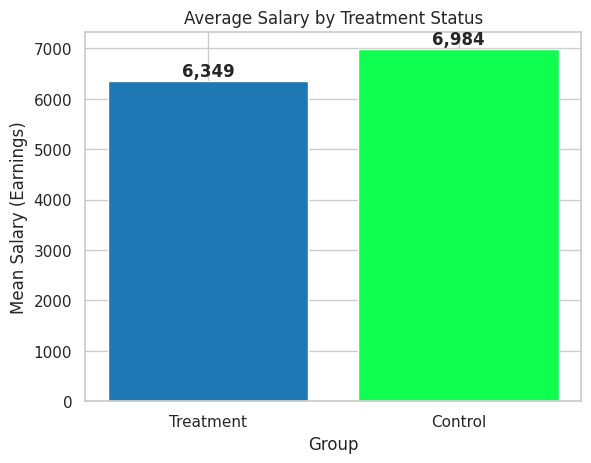

In [126]:
import matplotlib.pyplot as plt

# Compute means
mean_treat = lalonde_df.loc[lalonde_df['treat'] == 1, 'salary'].mean()
mean_control = lalonde_df.loc[lalonde_df['treat'] == 0, 'salary'].mean()

# Prepare data for plotting
groups = ['Treatment', 'Control']
means = [mean_treat, mean_control]

# Create bar chart
plt.bar(groups, means, color=['#1f77b4', '#0FFF50'])
plt.title('Average Salary by Treatment Status')
plt.ylabel('Mean Salary (Earnings)')
plt.xlabel('Group')

# Add numeric labels on top of bars
for i, v in enumerate(means):
    plt.text(i, v + 100, f'{v:,.0f}', ha='center', fontweight='bold')

plt.show()

### Plot using Seaborn

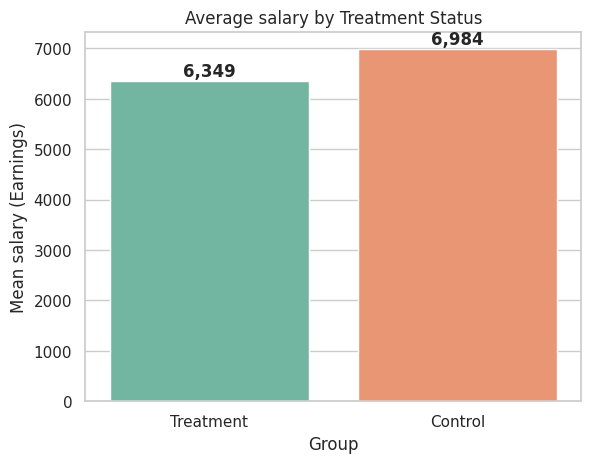

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute means into a DataFrame
mean_df = pd.DataFrame({
    'Group': ['Treatment', 'Control'],
    'Mean_salary': [mean_treat, mean_control]
})

# Plot
sns.barplot(
    data=mean_df,
    x='Group',
    y='Mean_salary',
    hue='Group',          # Add hue
    palette='Set2',
    legend=False          # Hide redundant legend
)

plt.title('Average salary by Treatment Status')
plt.ylabel('Mean salary (Earnings)')
plt.xlabel('Group')

# Add values on top of bars
for index, row in mean_df.iterrows():
    plt.text(index, row['Mean_salary'] + 100, f'{row["Mean_salary"]:,.0f}', ha='center', fontweight='bold')

plt.show()

### Note mean_treat < mean_control is not correct. We cannot compare those to determine the effect of the treatment in an observational study.

### This result would indicate that the job training program had a negative effect. Can we trust this result? NO. We will do PSM later.

### Simple regression analysis

In [128]:
import statsmodels.api as sm

# Define dependent (y) and independent (X) variables
X = lalonde_df['treat']          # independent variable
y = lalonde_df['salary']         # dependent variable

# Add constant (intercept) to the model
X = sm.add_constant(X)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X).fit()

# Display the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9338
Date:                Tue, 28 Oct 2025   Prob (F-statistic):              0.334
Time:                        00:04:19   Log-Likelihood:                -6346.4
No. Observations:                 614   AIC:                         1.270e+04
Df Residuals:                     612   BIC:                         1.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6984.1697    360.710     19.362      0.0

In [129]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Reshape X since scikit-learn expects 2D input
X = lalonde_df[['treat']]     # independent variable(s)
y = lalonde_df['salary']      # dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Print results
print("Intercept:", model.intercept_)
print("Coefficient for treat:", model.coef_[0])

# Predict salaries (optional)
lalonde_df['pred_salary'] = model.predict(X)

Intercept: 6984.169742307692
Coefficient for treat: -635.0262120374225


Note simple regression analysis leads to the same incorrect result as in the plots above: treat - control = -635

## The Balance between the Treat and Control groups - check!

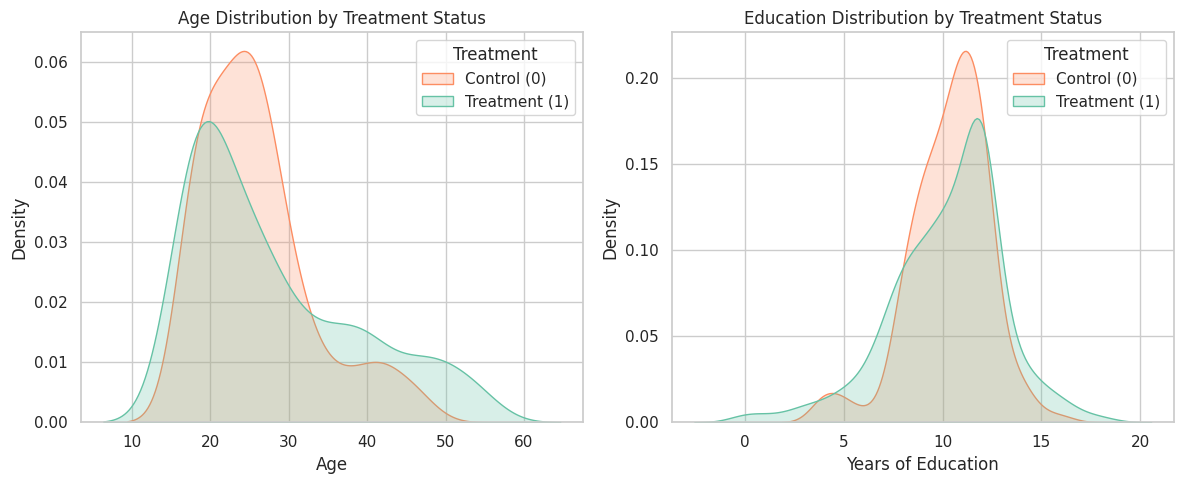

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot 1: Age
sns.kdeplot(
    data=lalonde_df,
    x='age',
    hue='treat',
    fill=True,
    common_norm=False,
    palette='Set2',
    ax=axes[0]
)
axes[0].set_title('Age Distribution by Treatment Status')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Density')
axes[0].legend(title='Treatment', labels=['Control (0)', 'Treatment (1)'])

# Plot 2: Education
sns.kdeplot(
    data=lalonde_df,
    x='educ',
    hue='treat',
    fill=True,
    common_norm=False,
    palette='Set2',
    ax=axes[1]
)
axes[1].set_title('Education Distribution by Treatment Status')
axes[1].set_xlabel('Years of Education')
axes[1].set_ylabel('Density')
axes[1].legend(title='Treatment', labels=['Control (0)', 'Treatment (1)'])

# Adjust layout
plt.tight_layout()
plt.show()

Checking the distribution of the pre-treatment variables leads to the conclusion that the groups are not similar.

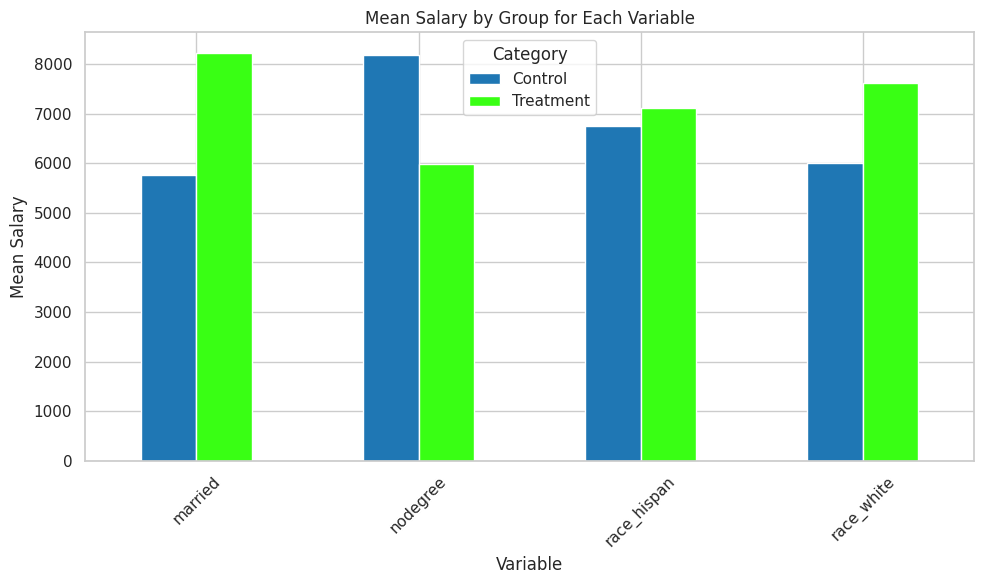

In [131]:
# Double check this plot for accuracy
import pandas as pd
import matplotlib.pyplot as plt

# Columns to analyze (exclude 'treat')
cols_to_plot = ['married', 'nodegree', 'race_hispan', 'race_white']

# Compute mean salary by each category
mean_salaries = []
for col in cols_to_plot:
    grouped = lalonde_df.groupby(col)['salary'].mean()
    mean_salaries.append(grouped)

# Combine into one DataFrame
mean_salary_df = pd.concat(mean_salaries, axis=1)
mean_salary_df.columns = cols_to_plot

# Rename index for legend
mean_salary_df.index = ['Control', 'Treatment']  # 0 -> Control, 1 -> Treatment

# Plot with custom colors
mean_salary_df.T.plot(kind='bar', figsize=(10,6), color=['#1f77b4', '#39ff14'])  # neon green

plt.title('Mean Salary by Group for Each Variable')
plt.ylabel('Mean Salary')
plt.xlabel('Variable')
plt.legend(title='Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### T-Test

In [132]:
from scipy.stats import ttest_ind

def perform_ttest(group1, group2):
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    return t_stat, p_val

pre_treatment_vars = ['age', 'educ', 're74', 're75']

treated = lalonde_df[lalonde_df['treat'] == 1]
control = lalonde_df[lalonde_df['treat'] == 0]

ttest_results = []
for var in pre_treatment_vars:
    t_stat, p_val = perform_ttest(treated[var], control[var])
    ttest_results.append({'Variable': var, 'T-Statistic': round(t_stat, 2), 'P-Value': f"{p_val:.3f}"})

ttest_results_df = pd.DataFrame(ttest_results)

ttest_results_df

,Variable,T-Statistic,P-Value
0,age,-2.99,0.003
1,educ,0.55,0.585
2,re74,-7.25,0.000
3,re75,-3.28,0.001


### Z Test for the categorical data

In [133]:
# Z Test for the categorical data

from statsmodels.stats.proportion import proportions_ztest

def perform_ztest(count1, nobs1, count2, nobs2):
    z_stat, p_val = proportions_ztest([count1, count2], [nobs1, nobs2])
    return z_stat, p_val

binary_vars = ['race_hispan', 'race_white', 'married', 'nodegree']

ztest_results = []
for var in binary_vars:
    count_treated = treated[var].sum()
    count_control = control[var].sum()
    nobs_treated = treated[var].count()
    nobs_control = control[var].count()
    z_stat, p_val = perform_ztest(count_treated, nobs_treated, count_control, nobs_control)
    ztest_results.append({'Variable': var, 'Z-Statistic': round(z_stat, 2), 'P-Value': f"{p_val:.3f}"})

ztest_results = pd.DataFrame(ztest_results)

ztest_results

,Variable,Z-Statistic,P-Value
0,race_hispan,-2.92,0.003
1,race_white,-12.69,0.000
2,married,-7.47,0.000
3,nodegree,2.62,0.009


The groups are not exchangeable, there are significant differences.

## **Multiple Linear Regression**

In [134]:

#import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the regression model using the formula interface
reg = smf.ols('salary ~ treat + age + educ + married + nodegree + race_hispan + race_white + re74 + re75',
              data=lalonde_df)
res = reg.fit()

# Show the regression results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     11.64
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           5.99e-17
Time:                        00:04:20   Log-Likelihood:                -6297.8
No. Observations:                 614   AIC:                         1.262e+04
Df Residuals:                     604   BIC:                         1.266e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1174.1296   2

### Now this is better. Treat = control + 1548. The job training program had a positive effect on salary.

### The caveat is that it assumes linear relationship.

## **Propensity Score Matching**

### Estimate Propensity Scores

In [135]:
from sklearn.linear_model import LogisticRegression

pre_treatment_vars = ['age', 'educ', 'married', 'nodegree', 'race_hispan', 'race_white', 're74', 're75']

X = lalonde_df[pre_treatment_vars]
y = lalonde_df['treat']


log_reg = LogisticRegression()
log_reg.fit(X, y)
lalonde_df['propensity_score_logistic'] = log_reg.predict_proba(X)[:, 1]

lalonde_df.head()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,rownames,treat,age,educ,married,nodegree,re74,re75,salary,race_hispan,race_white,pred_salary,propensity_score_logistic
0,NSW1,1,37,11,1,1,0.0,0.0,9930.0460,False,False,6349.14353,0.525712
1,NSW2,1,22,9,0,1,0.0,0.0,3595.8940,True,False,6349.14353,0.488417
2,NSW3,1,30,12,0,0,0.0,0.0,24909.4500,False,False,6349.14353,0.720243
3,NSW4,1,27,11,0,1,0.0,0.0,7506.1460,False,False,6349.14353,0.730300
4,NSW5,1,33,8,0,1,0.0,0.0,289.7899,False,False,6349.14353,0.740746


### Matching using Nearest Neighbors

In [136]:
from sklearn.neighbors import NearestNeighbors

treated = lalonde_df[lalonde_df['treat'] == 1]
control = lalonde_df[lalonde_df['treat'] == 0]

nn = NearestNeighbors(n_neighbors=1)

nn.fit(control[['propensity_score_logistic']])

distances, indices = nn.kneighbors(treated[['propensity_score_logistic']])

matched_control_indices = indices.flatten()
new_control = control.iloc[matched_control_indices]

matched_data = pd.concat([treated, new_control])
matched_data

,rownames,treat,age,educ,married,nodegree,re74,re75,salary,race_hispan,race_white,pred_salary,propensity_score_logistic
0,NSW1,1,37,11,1,1,0.00000,0.000,9930.0460,False,False,6349.143530,0.525712
1,NSW2,1,22,9,0,1,0.00000,0.000,3595.8940,True,False,6349.143530,0.488417
2,NSW3,1,30,12,0,0,0.00000,0.000,24909.4500,False,False,6349.143530,0.720243
3,NSW4,1,27,11,0,1,0.00000,0.000,7506.1460,False,False,6349.143530,0.730300
4,NSW5,1,33,8,0,1,0.00000,0.000,289.7899,False,False,6349.143530,0.740746
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,PSID111,0,51,11,0,1,48.98167,3813.387,1525.0140,False,True,6984.169742,0.223790
499,PSID315,0,31,12,0,0,6156.01600,0.000,4094.7800,False,True,6984.169742,0.074659
190,PSID6,0,37,9,1,1,13685.48000,12756.050,17833.2000,False,False,6984.169742,0.377923
511,PSID327,0,21,13,0,0,3015.31200,0.000,17627.8000,True,False,6984.169742,0.417112


### Standardized Mean Difference

In [137]:
def standarized_mean_difference(data, covars):

    treated = data[data['treat'] == 1]
    control = data[data['treat'] == 0]

    smd = {}

    for var in covars:
        mean_treated = treated[var].mean()
        mean_control = control[var].mean()
        sd_treated = treated[var].std()
        sd_control = control[var].std()
        smd[var] = abs(mean_treated - mean_control) / np.sqrt((sd_treated**2 + sd_control**2) / 2)

    return smd


smd_before_matching = standarized_mean_difference(lalonde_df, pre_treatment_vars)
smd_after_matching = standarized_mean_difference(matched_data, pre_treatment_vars)

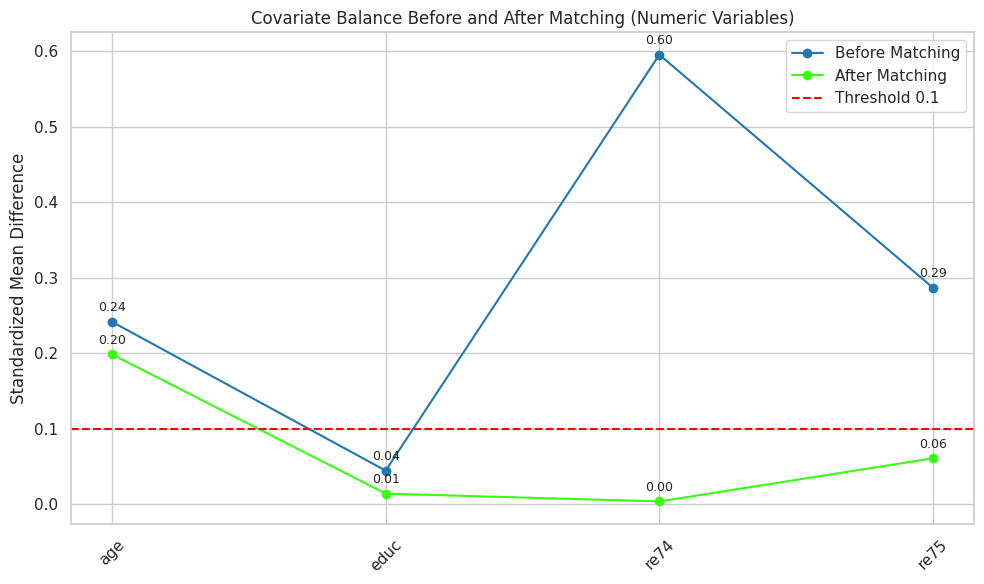

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude categorical variables
categorical_vars = ['married', 'nodegree', 'race_hispan', 'race_white']
numeric_vars = [var for var in smd_before_matching.keys() if var not in categorical_vars]

before = [smd_before_matching[var] for var in numeric_vars]
after = [smd_after_matching[var] for var in numeric_vars]

x = np.arange(len(numeric_vars))  # positions for x-axis

plt.figure(figsize=(10,6))

# Plot lines
plt.plot(x, before, marker='o', linestyle='-', label='Before Matching', color='#1f77b4')
plt.plot(x, after, marker='o', linestyle='-', label='After Matching', color='#39ff14')

# Threshold line
plt.axhline(0.1, color='red', linestyle='--', label='Threshold 0.1')

# Labels and title
plt.xticks(x, numeric_vars, rotation=45)
plt.ylabel('Standardized Mean Difference')
plt.title('Covariate Balance Before and After Matching (Numeric Variables)')
plt.legend()

# Annotate values
for i in x:
    plt.text(i, before[i] + 0.01, f'{before[i]:.2f}', ha='center', va='bottom', fontsize=9)
    plt.text(i, after[i] + 0.01, f'{after[i]:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Treatment Effect

In [139]:
treated_mean = matched_data[matched_data['treat'] == 1]['salary'].mean()
matched_control_mean =  matched_data[matched_data['treat'] == 0]['salary'].mean()

treatment_effect = treated_mean - matched_control_mean

print(treatment_effect)

985.203582540541


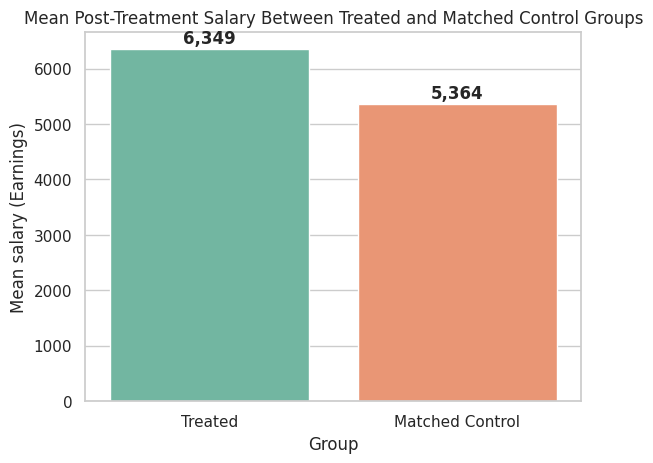

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute means into a DataFrame
mean_df = pd.DataFrame({
    'Group': ['Treated', 'Matched Control'],
    'Mean_salary': [treated_mean, matched_control_mean]
})

# Plot
sns.barplot(
    data=mean_df,
    x='Group',
    y='Mean_salary',
    hue='Group',          # Add hue
    palette='Set2',
    legend=False          # Hide redundant legend
)

plt.title('Mean Post-Treatment Salary Between Treated and Matched Control Groups')
plt.ylabel('Mean salary (Earnings)')
plt.xlabel('Group')

# Add values on top of bars
for index, row in mean_df.iterrows():
    plt.text(index, row['Mean_salary'] + 100, f'{row["Mean_salary"]:,.0f}', ha='center', fontweight='bold')

plt.show()

### The job training program lead to an average salary increase of 985$. That is after adjusting for differences in the confounding variables.